In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch as th
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import sys

torch.cuda.empty_cache()
sys.path.append('/content/drive/MyDrive/CID/')
sys.path.append('/content/drive/MyDrive/CID/data/')
sys.path.append('/content/drive/MyDrive/CID/networks/')

In [3]:
path='/content/drive/MyDrive/CID/data/'
params = dict()
params['IMG_DIR'] = path+'data/images' 
params['WORKERS']=2
params['IMSIZE']=64
params['BATCH_SIZE']=128

In [4]:
CUDA = False
cond_dim = 128
df_dim = 64
gf_dim = 64
z_dim = 50
emb_dim = 256

In [5]:
from cid_stage_1 import Conv_k3, Upblock,G_Stage1, weights_init, get_transform, get_data_loader, CondAugment_Model
from cid_stage_1 import KL_loss, cal_G_loss, cal_D_loss, scale, save_model, Text2FaceDataset, load_pickle

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

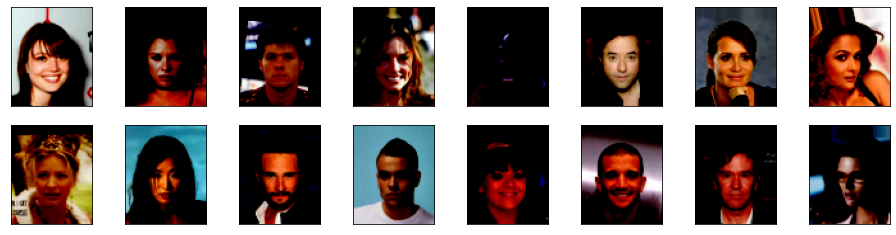

In [6]:
import numpy as np
import matplotlib.pyplot as plt

path='/content/drive/MyDrive/CID/data'
data_loader=get_data_loader(Text2FaceDataset(path+'/emd.pkl',path+'/data/images',img_transform=get_transform(params['IMSIZE'])),False,params['BATCH_SIZE'],params['WORKERS'])

# helper display function
def imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(data_loader)
d,images= dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(16, 4))
plot_size=16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [7]:
class ResBlock(nn.Module):
    def __init__(self, plane):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            Conv_k3(plane, plane),
            nn.BatchNorm2d(plane),
            nn.ReLU(True),
            Conv_k3(plane, plane),
            nn.BatchNorm2d(plane)
        )
        self.relu = nn.ReLU(True)
        
    def forward(self, x):
        tmp = x
        o = self.block(x)
        o = o + tmp
        return self.relu(o)

In [8]:
class CondAugment_Model2(nn.Module):
    def __init__(self):
        super(CondAugment_Model2,self).__init__()
        self.fc = nn.Linear(in_features=emb_dim, out_features=cond_dim*2,bias=True)
        self.relu = nn.ReLU(True)
        
    def convert(self, embed):
        x = self.relu(self.fc(embed))
        mean, sigma = x[:, : cond_dim], x[:, cond_dim:]
        return mean, sigma
    
    def forward(self, x):
        mean, sigma = self.convert(x)
        diag = torch.exp(sigma*0.5)
        if CUDA:
            normal_dis = (torch.FloatTensor(diag.size()).normal_()).cuda()
        else:
            normal_dis = (torch.FloatTensor(diag.size()).normal_())
        condition = (diag*normal_dis)+mean
        return condition, mean, sigma

In [9]:
class G_Stage2(nn.Module):
    def __init__(self, G_Stage1):
        super(G_Stage2, self).__init__()
        self.G1 = G_Stage1
        self.CA = CondAugment_Model2()
        for p in self.G1.parameters():
            p.requires_grad = False
        self.encoder = nn.Sequential(
            Conv_k3(3, gf_dim),
            nn.ReLU(True),
            nn.Conv2d(gf_dim, gf_dim * 4, 8, 8, 1, bias=False),
            nn.BatchNorm2d(gf_dim * 4),
            nn.ReLU(True))
        self.combine = nn.Sequential(
            Conv_k3(384, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        self.residual = nn.Sequential(
            ResBlock(256),
            ResBlock(256),
            ResBlock(256),
            ResBlock(256)
        )
        self.decoder = nn.Sequential(
            Upblock(256,128),
            Upblock(128,64),
            Upblock(64,32),
            Upblock(32,16),
            Conv_k3(16,3),
            nn.Tanh()
        )
        
    def forward(self, noise, emb):
        init_image, _, _ = self.G1(noise, emb)
        encoded = self.encoder(init_image)
        
        cond, m, s = self.CA(emb)
        cond = cond.view(-1, 128, 1, 1)
        cond = cond.repeat(1, 1, 4, 4)
        
        encoded_cond = torch.cat([encoded, cond],1)
        img_feature = self.combine(encoded_cond)
        img_feature = self.residual(img_feature)
        img = self.decoder(img_feature)
        
        return init_image, img, m, s

In [10]:
class D_output(nn.Module):
    def __init__(self, have_cond = True):
        super(D_output, self).__init__()
        self.have_cond = have_cond
        self.classifier = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=2),
            nn.Sigmoid()
        )
        if have_cond:
            cond_part = nn.Sequential(
                Conv_k3(in_p=512+cond_dim, out_p=512),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(0.2, inplace=True),
            )
            self.classifier = torch.nn.Sequential(*(list(cond_part)+list(self.classifier)))
        print(self.classifier)
            
    def forward(self, encoded_image, encoded_cond=None):
        if self.have_cond and encoded_cond is not None:
            cond = encoded_cond.view(-1,128, 1, 1)
            cond = cond.repeat(1, 1, 4, 4)
            image_with_cond = torch.cat([encoded_image, cond], 1)
        else:
            image_with_cond = encoded_image
        return self.classifier(image_with_cond).view(-1)

In [11]:
class D_Stage2(nn.Module):
    def __init__(self):
        super(D_Stage2, self).__init__()
        self.img_encoder = nn.Sequential(
            # start 3 x 64 x 64
            nn.Conv2d(3, df_dim, 4, 2, 1, bias=False), #=> 64 x 64 x 64
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(df_dim, df_dim*2, 4, 2, 1, bias=False), #=> 128 x 32 x 32
            nn.BatchNorm2d(df_dim*2),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(df_dim*2, df_dim*4, 4, 4, 1, bias=False), #=> 256 x 16 x 16
            nn.BatchNorm2d(df_dim*4),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(df_dim*4, df_dim*8, 2, 2, 1, bias=False), #=> 512 x 8 x 8
            nn.BatchNorm2d(df_dim*8),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(df_dim*8, df_dim*16, 2, 1, 1, bias=False), #=> 512 x 8 x 8
            nn.BatchNorm2d(df_dim*16),
            nn.LeakyReLU(0.2, True),

            Conv_k3(df_dim*16, df_dim*8), # 512 x 2 x 2
            nn.BatchNorm2d(df_dim*8),
            nn.LeakyReLU(0.2, True),

        )
        
        self.condition_classifier = D_output()
        self.uncondition_classifier = None
        
    def forward(self, img):
        img_feature = self.img_encoder(img)
        return img_feature

In [12]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

In [13]:
import pickle as pkl
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch_xla
import torch_xla.core.xla_model as xm
import warnings
import matplotlib
matplotlib.use('agg')

In [23]:
model_path= "/content/drive/MyDrive/CID/models"
losses=[]

In [24]:
# training

def main():
    device = 'cuda' if torch.cuda.is_available() else xm.xla_device()
    # load dataset with size 64x64
    transform = transforms.Compose([
                transforms.Resize(64),
                transforms.RandomCrop(64),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor()
                ])
    dataset = Text2FaceDataset(path+'/emd.pkl',path+'/data/images',img_transform=transform)
   
    #load model Stage-I generator and put it into Stage-II generator
    G1 = G_Stage1()
    G1.load_state_dict(torch.load(model_path+'/stage1/netG1_epoch_last.pth',map_location=torch.device('cpu')))
    G1.eval()
    netG = G_Stage2(G1).to(device)
    netG.apply(weights_init)
    netD = D_Stage2().to(device)
    netD.apply(weights_init)
    #netD.load_state_dict(torch.load(model_path+'/stage2/netD2_epoch_last.pth',map_location=torch.device('cpu')))
    #netG.load_state_dict(torch.load(model_path+'/stage2/netG2_epoch_last.pth',map_location=torch.device('cpu')))
    netD.train()
    netG.train()

    data_loader=get_data_loader(dataset,False,params['BATCH_SIZE'],params['WORKERS'])
    lr = 0.0002
    optD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999), eps=0.00000001)
    optG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999), eps=0.00000001)
    
    iters = 0
    samples = []
    for epochs in [320,160,80,40]:
      iters = 0
      samples=[]
      num_epoch = epochs
      for epoch in range(1,num_epoch+1):
          if epoch % 100 == 0 and epoch > 0:
              lr = lr*0.5
              for param_group in optG.param_groups:
                  param_group['lr'] = lr
              for param_group in optD.param_groups:
                  param_group['lr'] = lr
          for i, data in enumerate(data_loader,0):
              encoded_caps ,real_imgs = data
              batch_size = encoded_caps.size(0)
              real_imgs = scale(real_imgs.to(device))
              encoded_caps = encoded_caps.to(device)
              fixed_noise = torch.FloatTensor(batch_size, z_dim, 1, 1).normal_(0, 1).to(device)
              real_labels = (torch.FloatTensor(batch_size).fill_(1)).to(device)
              fake_labels = (torch.FloatTensor(batch_size).fill_(0)).to(device)

              ##update discriminator
              netD.zero_grad()
              # generate fake image
              noise = torch.FloatTensor(batch_size, z_dim, 1, 1).normal_(0, 1).to(device)
              init_img ,fake_imgs, m, s = netG(noise, encoded_caps)
              errD, errD_real, errD_wrong, errD_fake = cal_D_loss(netD, real_imgs, fake_imgs, real_labels, fake_labels, m)
              errD.backward()
              optD.step()
              if not CUDA:
                xm.mark_step()

              ##update generator
              netG.zero_grad()
              errG = cal_G_loss(netD, fake_imgs, real_labels, m) + KL_loss(m,s)
              errG.backward()
              optG.step()
              if not CUDA:
                xm.mark_step()

              if i%50 == 0:
                  losses.append((errD.item(), errG.item()))
                  print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_D_R: %.4f\tLoss_D_W: %.4f\tLoss_D_F %.4f'
                        % (epoch, num_epoch, i, len(data_loader),
                          errD.item(), errG.item(), errD_real, errD_wrong, errD_fake))
              if epoch%100==0:
                  with torch.no_grad():
                      _, fake, _, _  = netG(fixed_noise, encoded_caps)
                      fig = plt.figure(figsize=(8,8))
                      grid = make_grid(fake.detach().cpu(), nrow=8, normalize=True).permute(1,2,0).numpy()
                      samples.append(grid)
                      plt.imshow(grid)
                  
                  with open(model_path+'/results/train_samples_2.pkl', 'wb') as f:
                                    pkl.dump(samples, f)
          if CUDA:
                torch.save(netG.state_dict(), model_path+'/stage2/netG2_epoch_last.pth')
                torch.save(netD.state_dict(), model_path+'/stage2/netD2_epoch_last.pth')
          else:
                xm.save(netG.state_dict(), model_path+'/stage2/netG2_epoch_last.pth')
                xm.save(netD.state_dict(), model_path+'/stage2/netD2_epoch_last.pth')
       

if __name__ == '__main__':
    main()

"\ndef main():\n    device = 'cuda' if torch.cuda.is_available() else xm.xla_device()\n    # load dataset with size 64x64\n    transform = transforms.Compose([\n                transforms.Resize(64),\n                transforms.RandomCrop(64),\n                transforms.RandomHorizontalFlip(),\n                transforms.ToTensor()\n                ])\n    dataset = Text2FaceDataset(path+'/emd.pkl',path+'/data/images',img_transform=transform)\n   \n    #load model Stage-I generator and put it into Stage-II generator\n    G1 = G_Stage1()\n    G1.load_state_dict(torch.load(model_path+'/stage1/netG1_epoch_last.pth',map_location=torch.device('cpu')))\n    G1.eval()\n    netG = G_Stage2(G1).to(device)\n    netG.apply(weights_init)\n    netD = D_Stage2().to(device)\n    netD.apply(weights_init)\n    #netD.load_state_dict(torch.load(model_path+'/stage2/netD2_epoch_last.pth',map_location=torch.device('cpu')))\n    #netG.load_state_dict(torch.load(model_path+'/stage2/netG2_epoch_last.pth',map_

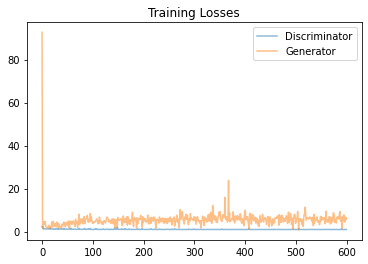

In [16]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [15]:
path="/content/drive/MyDrive/CID/data/"
data = load_pickle(path+"data.pkl")
desc = data["desc"][0:63]

from textEncoder import PretrainedEncoder
from embgen import Embedder

device = 'cuda' if torch.cuda.is_available() else 'cpu'
pretrained_encoder_file= "/content/drive/MyDrive/CID/networks/InferSent/models/infersent2.pkl"
pretrained_embedding_file= "/content/drive/MyDrive/CID/networks/InferSent/models/glove.840B.300d.txt"

text_encoder = PretrainedEncoder(
                model_file=pretrained_encoder_file,
                embedding_file=pretrained_embedding_file,
                device=device
            )

embedder = Embedder(
                  embedding_size=4096,
                  hidden_size=256,
                  num_layers=1
              )

text_encoder.eval()
embedder = embedder.to(device) 
embedder.eval()

Vocab size : 300000


Embedder(
  (network): Sequential(
    (0): LSTM(4096, 256, batch_first=True)
  )
)

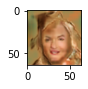

In [19]:
#testing

def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # load dataset with size 64x64
    transform = transforms.Compose([
                transforms.Resize(64),
                transforms.RandomCrop(64),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor()
                ])
    dataset = Text2FaceDataset(path+'/emd.pkl',path+'/data/images',img_transform=transform)
    data_loader=get_data_loader(dataset,False,params['BATCH_SIZE'],params['WORKERS'])
    #load model Stage-I generator and put it into Stage-II generator
    G1 = G_Stage1()
    G1.load_state_dict(torch.load(model_path+'/stage1/netG1_epoch_last.pth',map_location=torch.device('cpu')))
    G1.eval()
    netG = G_Stage2(G1).to(device)
    netG.apply(weights_init)
    netG.load_state_dict(torch.load(model_path+'/stage2/netG2_epoch_last.pth',map_location=torch.device('cpu')))
    netG.eval()
    
    num_epoch = 1
    iters = 0
    samples=[]
    for epoch in range(1,num_epoch+1):
        for i, data in enumerate(data_loader,0):
            encoded_caps,real_imgs = data
            batch_size = encoded_caps.size(0)
            real_imgs = scale(real_imgs.to(device))
            encoded_caps = encoded_caps.to(device) 
            fixed_noise = torch.FloatTensor(1, z_dim, 1, 1).normal_(0, 1).to(device)

            if i%1==0:
                with torch.no_grad():
                    sample_input ="""white female brown long hair happy face"""
                    input = [sample_input]
                    encoding = text_encoder(input)
                    encoding = encoding.reshape((1,encoding.shape[0], encoding.shape[1]))
                    embedding = embedder(torch.from_numpy(encoding).float().to(device))
                    encoded_caps = embedding.to(device)[0]
                    _,fake,_,_ = netG(fixed_noise, encoded_caps)
                    fig = plt.figure(figsize=(1,1))
                    grid = make_grid(fake.detach().cpu(), nrow=8, normalize=True).permute(1,2,0).numpy()
                    samples.append(grid)
                    plt.imshow(grid)
            
            break     
        #with open(model_path+'/results/test_samples_1.pkl', 'wb') as f:
        #                     pkl.dump(samples, f)
    

if __name__ == '__main__':
      main()

In [20]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    #fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for img in samples[:-1]:
        #ax.xaxis.set_visible(False)
        #ax.yaxis.set_visible(False)
        plt.imshow(img)

In [21]:
model_path='/content/drive/MyDrive/CID/models'
# Load samples from generator, taken while training
with open('/content/drive/MyDrive/CID/models/results/train_samples_2.pkl', 'rb') as f:
    samples = pkl.load(f)

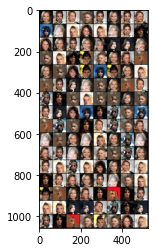

In [22]:
view_samples(-1, samples)